<a href="https://colab.research.google.com/github/Vamsi-Malineni/Research-work/blob/master/adaptive_without_batches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import copy

In [ ]:
# set random seed
np.random.seed(1234)
tf.set_random_seed(1234)


class pinn:
    # Initialize the class
    def __init__(self, data_idx, data_t0, data_sup_b_train, layers, N_train, batch_size,load = False, file=None):
        
#============================================================================================================================#
#=============================================Loading data ==================================================================#
#============================================================================================================================#
        self.data_t0 = data_t0
        self.data_sup_b_train = data_sup_b_train
        self.data_idx = data_idx
        self.N_train = N_train
        self.batch_size=batch_size

        self.lowb = data_idx.min(0)  
        self.upb = data_idx.max(0)

        self.layers = layers

#============================================================================================================================#
#=======================================Loading / Initializing NN============================================================#
#============================================================================================================================#
        if load==True:
            # collecting weights and biases from the pickle file
            self.weights,self.biases,self.ewanb,ac_bc,ac_ic=self.load_parameters_encoder(file,self.layers)
            
            # loading encoder weights and biases from pickle file
            self.encoder_weights_1=self.ewandb[0]
            self.encoder_biases_1=self.ewandb[2]

            self.encoder_weights_2=self.ewandb[1]
            self.encoder_biases_2=self.ewandb[3]
            
            # The adaptive constants are added here so as to start training from a check point
            self.beta=0.9
            self.adaptive_constant_bcs_val=ac_bc
            self.adaptive_constant_ics_val=ac_ic

        if load ==False:
            # Initializing weights and biases for model using xavier initialization method.
            self.weights, self.biases = self.initialize_NN(layers)

            # Adaptive weighting constants initialized to 1.
            self.beta=0.9
            self.adaptive_constant_bcs_val=np.array(1.0)  # arw for boundary conditions
            self.adaptive_constant_ics_val=np.array(1.0)  # arw for initial conditions

#============================================================================================================================#
#=============================================Specifying Placeholders========================================================#
#============================================================================================================================#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # learning rate placeholder
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        
        # initial condition placeholders
        self.x_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.v_ini_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # boundary condition placeholders
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc1_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc2_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc3_tf = tf.placeholder(tf.float32, shape=(None, 2))

        self.x_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.y_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.t_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc4_tf = tf.placeholder(tf.float32, shape=(None, 2))

        # domain residual placeholders
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # defining a placeholder for adaptive constant
        self.adaptive_constant_bcs_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_bcs_val.shape)
        self.adaptive_constant_ics_tf=tf.placeholder(tf.float32,shape=self.adaptive_constant_ics_val.shape)
        
#============================================================================================================================#
#=============================================Evaluating Predictions=========================================================#
#============================================================================================================================#

        # Initial value predictions
        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred = self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        # Boundary value predictions

        self.u_bc1_pred, self.v_bc1_pred,_,_,_,_= self.net_f_NS(self.x_bc1_tf, self.y_bc1_tf,self.t_bc1_tf)
        self.u_bc2_pred, self.v_bc2_pred,_,_,_,_= self.net_f_NS(self.x_bc2_tf, self.y_bc2_tf,self.t_bc2_tf)
        self.u_bc3_pred, self.v_bc3_pred,_,_,_,_= self.net_f_NS(self.x_bc3_tf, self.y_bc3_tf,self.t_bc3_tf)
        self.u_bc4_pred, self.v_bc4_pred,_,_,_,_= self.net_f_NS(self.x_bc4_tf, self.y_bc4_tf,self.t_bc4_tf)
        
        self.U_bc1_pred = tf.concat([self.u_bc1_pred, self.v_bc1_pred], axis=1)
        self.U_bc2_pred = tf.concat([self.u_bc2_pred, self.v_bc2_pred], axis=1)
        self.U_bc3_pred = tf.concat([self.u_bc3_pred, self.v_bc3_pred], axis=1)
        self.U_bc4_pred = tf.concat([self.u_bc4_pred, self.v_bc4_pred], axis=1)

        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

#============================================================================================================================#
#=============================================Defining loss fn===============================================================#
#============================================================================================================================#

        self.loss_bcs=self.adaptive_constant_bcs_tf*(tf.reduce_mean(tf.square(self.U_bc1_pred - self.U_bc1_tf)+tf.square(self.U_bc2_pred - self.U_bc2_tf)+tf.square(self.U_bc3_pred - self.U_bc3_tf)+tf.square(self.U_bc4_pred - self.U_bc4_tf)))

        self.loss_ics=self.adaptive_constant_ics_tf*(tf.reduce_mean(tf.square(self.u_ini_tf - self.u_ini_pred)) + tf.reduce_mean(tf.square(self.v_ini_tf - self.v_ini_pred)))
        
        # Defining loss function for residual in the domain 
        
        self.loss_res= tf.reduce_mean(tf.square(self.f_u_pred)) + tf.reduce_mean(tf.square(self.f_v_pred)) + tf.reduce_mean(tf.square(self.f_e_pred))


        # set loss function
        self.loss =self.loss_res + self.loss_bcs + self.loss_ics

#============================================================================================================================#
#=============================================Setting up optimizer===========================================================#
#============================================================================================================================#
        self.global_step=tf.Variable(0,trainable=False)
        starter_learning_rate=1e-3
        self.learning_rate=tf.train.exponential_decay(starter_learning_rate,self.global_step,1000,0.9,staircase=False)

        # set optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss,global_step=self.global_step)

#============================================================================================================================#
#=============================================Adaptive weighting constants===================================================#
#============================================================================================================================#

        # Collecting gradients of the individual loss terms wrt the parameters of the network
        self.grad_res=[]
        self.grad_bcs=[]
        self.grad_ics=[]
        
        for i in range(len(self.layers)-1):
          self.grad_res.append(tf.gradients(self.loss_res,self.weights[i])[0])
          self.grad_bcs.append(tf.gradients(self.loss_bcs,self.weights[i])[0])
          self.grad_ics.append(tf.gradients(self.loss_ics,self.weights[i])[0])
        
        # Collecting the adaptive constants for initial and boundary conditions
        self.adaptive_constant_bcs_list=[]
        self.adaptive_constant_ics_list=[]

        self.adaptive_constant_bcs_log=[]
        self.adaptive_constant_ics_log=[]

        for i in range(len(self.layers)-1):
          self.adaptive_constant_bcs_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_bcs[i]))
          )
          self.adaptive_constant_ics_list.append(
              tf.reduce_max(tf.abs(self.grad_res[i])) / tf.reduce_mean(tf.abs(self.grad_ics[i]))
          )
        
        self.adaptive_constant_bcs=tf.reduce_max(tf.stack(self.adaptive_constant_bcs_list))
        self.adpative_constant_ics=tf.reduce_max(tf.stack(self.adaptive_constant_ics_list))
        
#============================================================================================================================#
#=============================================initializing session===========================================================#
#============================================================================================================================#

        # Initializing Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

#============================================================================================================================#
#=============================================Data in batches================================================================#
#============================================================================================================================#

        # Creating batches for domain data
    def summon_batch_domain(self,batch_size,start):
      ''' 
      This function returns a list containing randomnly picked points from the domain
      '''
      data=copy.deepcopy(self.data_idx)
      points=[]

      for i in range(start,len(data),batch_size): # Something is wrong here

        points.append(data[i:i+batch_size,0:3])
        break # breaks after the first iteration

      return points

    def domain_batches(self,batch_size):
      '''
      This function is used to call the domain data points in batches
      This function returns an array of arrays of shape(438,1) each of the 438 arrays
      will have batch size number of points
      '''
      batches=[]
      num_batches=math.ceil(self.N_train/batch_size)

      for i in range(0,len(data_idx),batch_size):
        batches.append(self.summon_batch_domain(batch_size,i))

      return np.asarray(batches,dtype=object) 

# Creating batches for initial conditions
    def summon_batch_ic(self,batch_size,start):

      data=copy.deepcopy(data_t0)
      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points
    def ic_batches(self,batch_size):
      batches=[]
      num_batches=math.ceil(self.data_t0.shape[0]/batch_size)

      for i in range(0,len(self.data_t0),batch_size):
        batches.append(self.summon_batch_ic(batch_size,i))

      return np.asarray(batches,dtype=object)       

# Creatng batches for boundary condition
    def summon_batch_bc(self,batch_size,bc_con,start):
      
      if bc_con==1:
        data=copy.deepcopy(data_sup_b_train[0:20000,:])
      elif bc_con==2:
        data=copy.deepcopy(data_sup_b_train[20000:40000,:])
      elif bc_con==3:
        data=copy.deepcopy(data_sup_b_train[40000:60000,:])
      elif bc_con==4:
        data=copy.deepcopy(data_sup_b_train[60000:80000,:])

      points=[]

      for i in range(start,len(data),batch_size): 

        points.append(data[i:i+batch_size])
        break # breaks after the first iteration

      return points	
    
    def bc_batches(self,batch_size,bc_con):

      batches=[]
      
      for i in range(0,int(len(data_sup_b_train)/4),batch_size):
        batches.append(self.summon_batch_bc(batch_size,bc_con,i))

      return np.asarray(batches,dtype=object) 

#============================================================================================================================#
#=============================================Utility fns= ==================================================================#
#============================================================================================================================#

# initialize the weights and biases
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# saving the weights and biases for transfer learning
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
        ac_bc=(self.adaptive_constant_bcs_val)
        ac_ic=(self.adaptive_constant_ics_val)
                
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases,ac_bc,ac_ic],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path("D:\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases,ac_bc,ac_ic=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            W=tf.Variable(weights[num])
            b=tf.Variable(biases[num])
            tf_weights.append(W)
            tf_biases.append(b)
         
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases,ac_bc,ac_ic
    
    
#============================================================================================================================#
#=============================================Neural_net setup===============================================================#
#============================================================================================================================#


    def neural_net(self, X):
        num_layers = len(self.weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    # supervised data driven
    def net_NS(self, x, y, t):

        
        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        psi_p = self.neural_net(tf.concat([x, y, t], 1))
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = 0.0

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

#============================================================================================================================#
#=============================================Training algorithms============================================================#
#============================================================================================================================#

#     def Adam_train(self, epochs=5000,file_save=''):

#         start_time = time.time()
        
#         for epoch in range(epochs):
#           # number of batch will vary for domain, initial and boundary conditions.
#             dom_bat_no=np.random.randint(1,(math.ceil(self.N_train/self.batch_size)))
#             init_bat_no=np.random.randint(1,(math.ceil(self.data_t0.shape[0]/self.batch_size)))
#             bound_bat_no=np.random.randint(1,(math.ceil((self.data_sup_b_train.shape[0]/4)/self.batch_size)))
            
#             # call batches here 
#             d_batch = self.domain_batches (self.batch_size)[dom_bat_no][0]
#             i_batch = self.ic_batches     (self.batch_size)[init_bat_no][0]
#             b_batch1 = self.bc_batches     (self.batch_size,1)[bound_bat_no][0]
#             b_batch2 = self.bc_batches     (self.batch_size,2)[bound_bat_no][0]
#             b_batch3 = self.bc_batches     (self.batch_size,3)[bound_bat_no][0]
#             b_batch4 = self.bc_batches     (self.batch_size,4)[bound_bat_no][0]
            
#             tf_dict = {
#                   self.x_ini_tf: i_batch[:,0:1] , 
#                   self.y_ini_tf: i_batch[:,1:2] ,
#                   self.t_ini_tf: i_batch[:,2:3] , 
#                   self.u_ini_tf: i_batch[:,3:4],
#                   self.v_ini_tf: i_batch[:,4:5] , 

#                   self.x_bc1_tf: b_batch1[:,0:1] ,
#                   self.y_bc1_tf: b_batch1[:,1:2] , 
#                   self.t_bc1_tf: b_batch1[:,2:3] ,
#                   self.U_bc1_tf: b_batch1[:,3:5] ,

#                   self.x_bc2_tf: b_batch2[:,0:1] ,
#                   self.y_bc2_tf: b_batch2[:,1:2] , 
#                   self.t_bc2_tf: b_batch2[:,2:3] ,
#                   self.U_bc2_tf: b_batch1[:,3:5] ,
                  
#                   self.x_bc3_tf: b_batch3[:,0:1] ,
#                   self.y_bc3_tf: b_batch3[:,1:2] , 
#                   self.t_bc3_tf: b_batch3[:,2:3] ,
#                   self.U_bc3_tf: b_batch1[:,3:5] ,
                  
#                   self.x_bc4_tf: b_batch4[:,0:1] ,
#                   self.y_bc4_tf: b_batch4[:,1:2] , 
#                   self.t_bc4_tf: b_batch4[:,2:3] ,
#                   self.U_bc4_tf: b_batch1[:,3:5] ,
                  
#                   self.x_tf: d_batch[:,0:1] , 
#                   self.y_tf:d_batch[:,1:2] , 
#                   self.t_tf:d_batch[:,2:3] ,

#                   self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
#                   self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val}

#             # add the tf dict here 
#             self.sess.run(self.train_op_Adam, tf_dict)

#             # Print
#             if epoch % 10 == 0:
#                 elapsed = time.time() - start_time
#                 loss_value = self.sess.run(self.loss, tf_dict)
#                 adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,tf_dict)
#                 adaptive_constant_ics_val=self.sess.run(self.adpative_constant_ics,tf_dict)

#                 self.adaptive_constant_bcs_val=adaptive_constant_bcs_val* (1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
#                 self.adaptive_constant_ics_val=adaptive_constant_ics_val* (1.0-self.beta)+self.beta*self.adaptive_constant_ics_val

#                 print('epoch: %d, Loss: %.3e, Time: %.2f' %
#                       (epoch, loss_value, elapsed))
#                 print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
#                 print("constant_ics_val: {:.3f}".format(self.adaptive_constant_ics_val))
#                 start_time = time.time()
            
#             if epoch !=0 and epoch %1000==0:
#                 self.save_parameters(file_save)
    def Adam_train(self, epochs=5000,file_save=''):

        start_time = time.time()
        tf_dict = {
              self.x_ini_tf: self.data_t0[:,0:1], # Initial values
              self.y_ini_tf: self.data_t0[:,1:2],
              self.t_ini_tf: self.data_t0[:,2:3], 
              self.u_ini_tf: self.data_t0[:,3:4],
              self.v_ini_tf: self.data_t0[:,4:5], 

              self.x_bc1_tf: self.data_sup_b_train[0:20000,0:1] ,# boundary conditions
              self.y_bc1_tf: self.data_sup_b_train[0:20000,1:2], 
              self.t_bc1_tf: self.data_sup_b_train[0:20000,2:3],
              self.U_bc1_tf: self.data_sup_b_train[0:20000,3:5],

              self.x_bc2_tf: self.data_sup_b_train[20000:40000,0:1] ,
              self.y_bc2_tf: self.data_sup_b_train[20000:40000,1:2] , 
              self.t_bc2_tf: self.data_sup_b_train[20000:40000,2:3] ,
              self.U_bc2_tf: self.data_sup_b_train[20000:40000,3:5] ,

              self.x_bc3_tf: self.data_sup_b_train[40000:60000,0:1] ,
              self.y_bc3_tf: self.data_sup_b_train[40000:60000,1:2] , 
              self.t_bc3_tf: self.data_sup_b_train[40000:60000,2:3] ,
              self.U_bc3_tf: self.data_sup_b_train[40000:60000,3:5] ,

              self.x_bc4_tf: self.data_sup_b_train[60000:80000,0:1] ,
              self.y_bc4_tf: self.data_sup_b_train[60000:80000,1:2] , 
              self.t_bc4_tf: self.data_sup_b_train[60000:80000,2:3] ,
              self.U_bc4_tf: self.data_sup_b_train[60000:80000,3:5] ,

              self.x_tf: self.data_idx[:,0:1] , # domain 
              self.y_tf: self.data_idx[:,1:2] , 
              self.t_tf: self.data_idx[:,2:3] ,

              self.adaptive_constant_bcs_tf: self.adaptive_constant_bcs_val,
              self.adaptive_constant_ics_tf: self.adaptive_constant_ics_val}
        
        for epoch in range(epochs):

            # add the tf dict here 
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if epoch % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                adaptive_constant_bcs_val=self.sess.run(self.adaptive_constant_bcs,tf_dict)
                adaptive_constant_ics_val=self.sess.run(self.adpative_constant_ics,tf_dict)

                self.adaptive_constant_bcs_val=adaptive_constant_bcs_val* (1.0-self.beta)+self.beta*self.adaptive_constant_bcs_val
                self.adaptive_constant_ics_val=adaptive_constant_ics_val* (1.0-self.beta)+self.beta*self.adaptive_constant_ics_val

                print('epoch: %d, Loss: %.3e, Time: %.2f' %
                      (epoch, loss_value, elapsed))
                print("constant_bcs_val: {:.3f}".format(self.adaptive_constant_bcs_val))
                print("constant_ics_val: {:.3f}".format(self.adaptive_constant_ics_val))
                start_time = time.time()
            
            if epoch !=0 and epoch %1000==0:
               self.save_parameters(file_save)

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

#============================================================================================================================#
#=============================================Predicting for test_data=======================================================#
#============================================================================================================================#


    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:
def load_data(N_train):
    # Load Data
    #path=r"C:\Users\vamsi_oe20s302\Downloads\all_pressures"
    path=r"C:\Users\Vamsi\Downloads\all_pressures"
    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1

    # need add unsupervised part
    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)

    # Concatenating all the points
    data1=np.concatenate([x ,y ,t , u , v ,p ],1)

    data2=data1[:,:][data1[:,2]<=20]
    data3=data2[:,:][data2[:,0]>=xmin]
    data4=data3[:,:][data3[:,0]<=xmax]
    data5=data4[:,:][data4[:,1]>=ymin]

    # Creating domain dataset size= (2000000,6)
    # It is from this dataset, we extract idx points for calculating the NS residual
    data_domain=data5[:,:][data5[:,1]<=ymax]

    # Creating initial condition dataset size=(10000,6)
    data_t0=data_domain[:,:][data_domain[:,2]==0]

    # Defining boundary conditions for the data
    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    # Creating boundary conditions dataset size=(80000,6)
    data_sup_b_train = np.concatenate([bc1_data,bc2_data,bc3_data,bc4_data], 0)

    # Creating random indexes for domain residual sampling points
    idx = np.random.choice(data_domain.shape[0], N_train, replace=False)

    # Extracting random points(x,y,t) from the domain dataset
    data_idx=data_domain[idx][:,0:3]
    
    return data_idx,data_t0,data_sup_b_train


In [ ]:

if __name__ == "__main__":

    N_train = 14000
    batch_size= 32

    #layers = [3, 50,50,50, 2]
    layers=[3]+10*[4*50]+[2]
    
    # loading data
    data_idx,data_t0,data_sup_b_train = load_data(N_train)
    
    # Initializing the model for training
    model = pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=False,file=None)
    
#     Initializing model for testing by loading the pickle file
#     filedr='' # Enter the name of the pickle file
#     model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)
    
#     Enter the name of the parameters file
    file_save='params_1' 
#      Training the model
    model.Adam_train(50000,file_save)







Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





In [ ]:
def load_testdata(snap):
    path=r"C:\Users\Vamsi\Downloads\all_pressures"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/static_press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    
    N=xy.shape[0]
    T=t.shape[0]
    
    TT = np.tile(t, (1,N)).T # N x T
    
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]
    X_star=[x_star,y_star,t_star]
    
    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]
    Y_star=[u_star,v_star,p_star]
    
    return X_star,Y_star

In [ ]:
# # Testing the load functionality for errors :
# filedr='params_3_laptop_run' # Enter the name of the pickle file
# model= pinn(data_idx,data_t0,data_sup_b_train,layers,N_train,batch_size,load=True,file=filedr)


# # Prediction
X_star,Y_star=load_testdata(np.array([100]))
u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

# # Error
error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)

print('Error u: %e' % error_u)
print('Error v: %e' % error_v)
print('Error p: %e' % error_p)

Error u: 1.239984e-01
Error v: 9.834068e-01
Error p: 3.253094e+00


# Plotting the Predicted Velocity

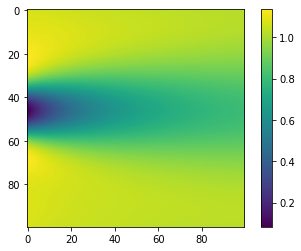

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.colorbar()

# Plotting the actual velocity 

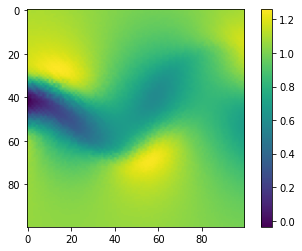

In [ ]:
upl=np.reshape(Y_star[0],(100,100))
plt.imshow(upl)
plt.colorbar()